In [1]:
import os
import pickle as pkl
from random import seed

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from scipy.stats import pearsonr
seed(1234)
np.random.seed(1234)
torch.random.manual_seed(1234)

In [2]:
import dill
with open('models/scASTRAL_final_pipeline.pkl', 'rb') as handle:
    serialized = handle.read()
model = dill.loads(serialized)

In [27]:
#model = pkl.load(open('models/scASTRAL_final_pipeline.pkl','rb'))

response = pd.read_csv('data/afatinib.csv')
to_test = ["HCC1937","HCC38","HCC1187","CAL51","DU4475","HS578T",
           "BT549","MDAMB436", "BT20","HDQP1","CAL851","HCC1143"]

#"SUM159PT","SUM229PE" ,"SUM1315MO2","SUM185","SUM149PT","HCC70",

signature = pd.read_csv('data/signature.csv')
signature = list(signature['ensembl_gene_id'])

In [28]:
response['cl'] = [p.replace('-','') for p in response['Cell line']]
response['log(IC50)'] = np.log2(response['IC50'])
response = response.loc[ [p in to_test for p in response['cl']] ,['cl','log(IC50)'] ]
response['score']=np.nan

In [122]:
res = []
for file in os.listdir('data/cell_line'):
    cell_line,extension = file.split('.')
    if extension == 'csv' and cell_line in to_test:
        df = pd.read_csv(f"data/cell_line/{file}",index_col=0)
        df = df.loc[:,signature]
        response.loc[response['cl']==cell_line,'score']= model.predict_log_proba(df)[:,1].mean()
        df['cl']=cell_line
        df['ic50']=float(response.loc[response['cl']==cell_line,'log(IC50)'])
        res.append(df)


/tmp/ipykernel_32546/1686166963.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df['ic50']=float(response.loc[response['cl']==cell_line,'log(IC50)'])
/tmp/ipykernel_32546/1686166963.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df['ic50']=float(response.loc[response['cl']==cell_line,'log(IC50)'])
/tmp/ipykernel_32546/1686166963.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df['ic50']=float(response.loc[response['cl']==cell_line,'log(IC50)'])
/tmp/ipykernel_32546/1686166963.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df['ic50']=float(response.loc[response['cl']==cell_line,'l

In [124]:
df['ic50']

barcode
AAAAGGCTTAGG    2.39605
AAAATCGCCCAC    2.39605
AAACAATTTTGG    2.39605
AAAGGGAATAGT    2.39605
AAAGTCAGGATG    2.39605
                 ...   
TTTGAGGCGGAC    2.39605
TTTGGTCATAGC    2.39605
TTTTATCGAACA    2.39605
TTTTGGCACTCT    2.39605
TTTTTATTAAAG    2.39605
Name: ic50, Length: 415, dtype: float64

In [125]:
res = pd.concat(res)
X = res.iloc[:,:-2]
cl = res['cl']
ic = res['ic50']

In [127]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
cl = le.fit_transform(cl)

In [95]:
from umap import UMAP
toplot = UMAP().fit_transform(X)

/home/jerko/PycharmProjects/scASTRAL/venv/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jerko/PycharmProjects/scASTRAL/venv/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jerko/PycharmProjects/scASTRAL/venv/lib/python3.11

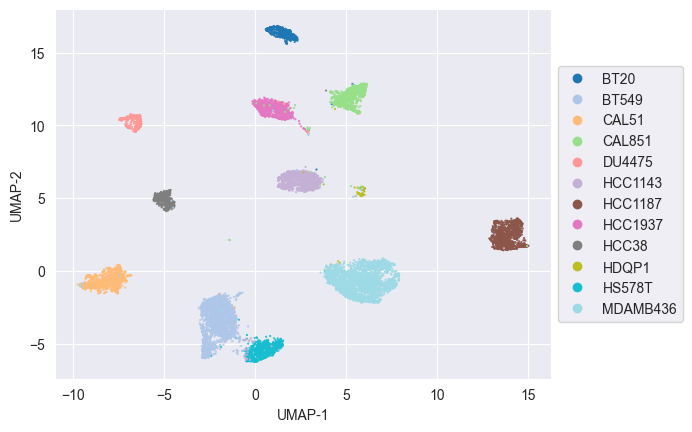

In [158]:

scatter = plt.scatter(toplot[:,0],toplot[:,1],c=cl,s=.3, cmap='tab20')
scatter.legend_elements(prop='colors', num=18)
handles = scatter.legend_elements(prop="colors")[0]
plt.legend(handles=handles,labels=list(le.classes_),loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.savefig('umap.pdf', bbox_inches='tight')
plt.show()

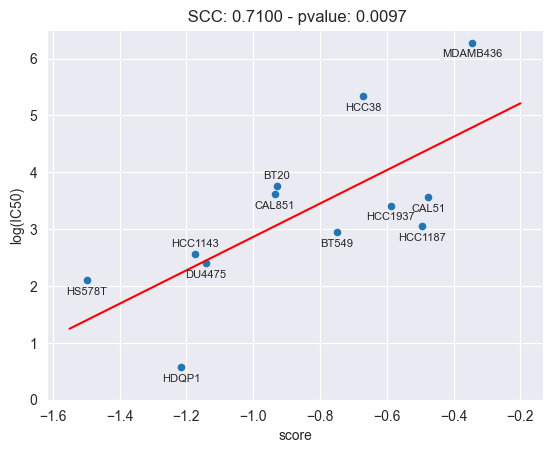

In [83]:
from scipy.stats import linregress
response = response.dropna()
test = pearsonr(response['log(IC50)'],response['score'])
response.plot.scatter(y='log(IC50)',x='score', title=f" SCC: {test.statistic:.4f} - pvalue: {test.pvalue:.4f}")
rss = linregress(response['score'],response['log(IC50)'])
x = np.array([-1.55, -.2])
plt.plot(x, rss.intercept + rss.slope*x, 'r')
plt.ylim(0,6.5)
for idx, row in response.iterrows():
    if row['cl'] in ['BT20','HCC1143']:
        plt.text(row['score'],row['log(IC50)']+.1, row['cl'], va='bottom', ha='center',fontsize=8)
    else:
        plt.text(row['score'],row['log(IC50)']-.11, row['cl'], va='top', ha='center',fontsize=8)
plt.savefig('result.pdf')
plt.show()

AttributeError: 'Axes' object has no attribute 'show'